# Investigation on Hu-Lu-Yang weights

Following investigation shows that 

Hu, H., Lu, Z., & Yang, W. (2007). Fitting molecular electrostatic potentials from quantum mechanical calculations. Journal of Chemical Theory and Computation, 3(3), 1004–1013. https://doi.org/10.1021/ct600295n

https://github.com/theochem/horton/blob/master/horton/espfit/cost.py

```
The density-based criterion. This is a three-tuple with rho, lnrho0
and sigma. rho is the atomic or the pro-atomic electron density on
the same grid as the ESP data. lnrho0 and sigma are parameters
defined in JCTC, 3, 1004 (2007), DOI:10.1021/ct600295n. The weight
function takes the form::

exp(-sigma*(ln(rho) - lnrho0)**2)

Note that the density, rho, should not contain depletions in the
atomic cores, as is often encountered with pseudo-potential
computations. In that case it is recommended to construct a
promolecular density as input for this option.
```


    horton-esp-cost.py --help
    
```
[...]
  --wdens [WDENS]       Define weights based on an electron density. The
                        argument has the following format:
                        "dens.cube:lnrho0:sigma". All arguments are optional.
                        The density is loaded from the file in the first field
                        or a prodensity is constructed if the file is not
                        given. The cube file must have the same header is the
                        potential data file. The second and third field are
                        parameters of the wieght function and are defined in
                        DOI:10.1021/ct600295n. The default is ':-9:0.8'.
  --wnear WNEAR [WNEAR ...]
                        Define weights that go to zero near the nuclei.
                        Multiple arguments are allowed and have the following
                        format: "number:r0:gamma". The first field is the
                        elemenet number and the last two fields define the
                        switching function and are in Angstrom. The last field
                        is optional and is 0.5*A by default. The second field
                        is the middle of the switching function. The third
                        field is the half width of the switching function. If
                        number is zero, the argument applies to all elements.
  --wfar WFAR           Define weights that go to zero far from the nuclei.
                        The argument has the following format: "r0:gamma". The
                        first field is the distance (to the closest nucleus)
                        at which the weight switches to zero. The second field
                        is the half width of the switching function. To avoid
                        artifacts, a smooth version of "distance to the
                        closest nucleus" is used. The second field is optional
                        and has 1.0 as default value
  --wsave WSAVE         Save the weights array to the given cube file.

[...]
```

Use extended wrapper like

```
./horton-esp-cost.sh --sign --esp-infile-cube sandbox/system100.vHtg_ua.cube \
    --dens-infile-cube sandbox/system100.rho_ua.cube \
    --cost-outfile-hdf5 sandbox/system100.cost_ua_neg.h5 \
    --weights-outfile-cube sandbox/system100.weights_ua.cube \
    2>&1 | tee sandbox/horton-esp-cost-ua-neg.log
```

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from ase.units import Bohr
from ase.io.cube import read_cube_data
from ase.io import write

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure

In [108]:
# weights as recommended by 
### Hu, H., Lu, Z., & Yang, W. (2007). 
### Fitting molecular electrostatic potentials from quantum mechanical calculations. 
### Journal of Chemical Theory and Computation, 3(3), 1004–1013. 
### https://doi.org/10.1021/ct600295n
def W(rho,sigma=0.8,lnrhoref=-9.0):
    return np.exp( -sigma * (np.log(rho) - lnrhoref)**2)

In [5]:
W(0.1)

2.6040510761119198e-16

In [112]:
rho = np.linspace(np.exp(-18.0),1,200)

In [113]:
# for interpreting the plots, remember:
# cube files store and Horton processes densities in Bohr^-3

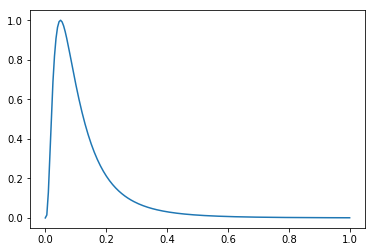

In [114]:
plt.plot(rho,W(rho,sigma=0.8,lnrhoref=-3))

In [91]:
rho_logspaced = np.logspace(-9.0,-1.0,200)

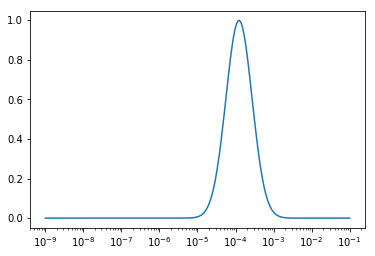

In [117]:
plt.semilogx(rho_logspaced,W(rho_logspaced,lnrhoref=-9))

# Water sample

In [11]:
# for interpreting the plots, remember:
# cube files store and Horton processes densities in Bohr^-3
# however, using ASE's read_cube_data(...) converts 
# distance measures into ASE units (i.e. Angstrom)
# but leaves the actual cube_data untouched
# in order to integrate over the data, the volume element 
# has to be expressed in [Bohr^3], as done below

# Not to be confused: 
# ase.units.Bohr = 0.529... expresses [Angstrom / Bohr]
# thus multiplying unit volume (in ASE Ansgtrom**3) 
# with 1/ase.units.Bohr**3 does the conversion

In [12]:
infile_h2o_cube = 'examples/h2o.rho.cube'
h2o_cube_data, h2o_cube_atoms = read_cube_data(infile_h2o_cube)

In [13]:
h2o_cube_data.ndim

3

In [14]:
h2o_unit_cell = h2o_cube_atoms.cell.diagonal() / h2o_cube_data.shape
h2o_unit_volume = np.prod(h2o_unit_cell)
h2o_q_el = h2o_cube_data.sum()*h2o_unit_volume/Bohr**3 # integrate electron density
h2o_q_core = 0
for a in h2o_cube_atoms: # count positive core charges
    h2o_q_core += a.number

In [15]:
h2o_q_el, h2o_q_core, h2o_q_core - h2o_q_el

(9.9999280284562762, 10, 7.1971543723847731e-05)

In [16]:
h2o_rho = h2o_cube_data*h2o_unit_volume/Bohr**3

In [17]:
[h2o_rho.min(),h2o_rho.max()]

[0.0, 0.76294327659326477]

Data maximum 0.7629432765932648.
Data minimum 0.0.
Span of data 0.7629432765932648.
Shift data by -1.0.
Span of logarithms: 0.2462383389250448.
Magnitude of logarithm: 0.2462383389250448.
Plot isosurfaces of normalized log values in interval [0, 0.01]


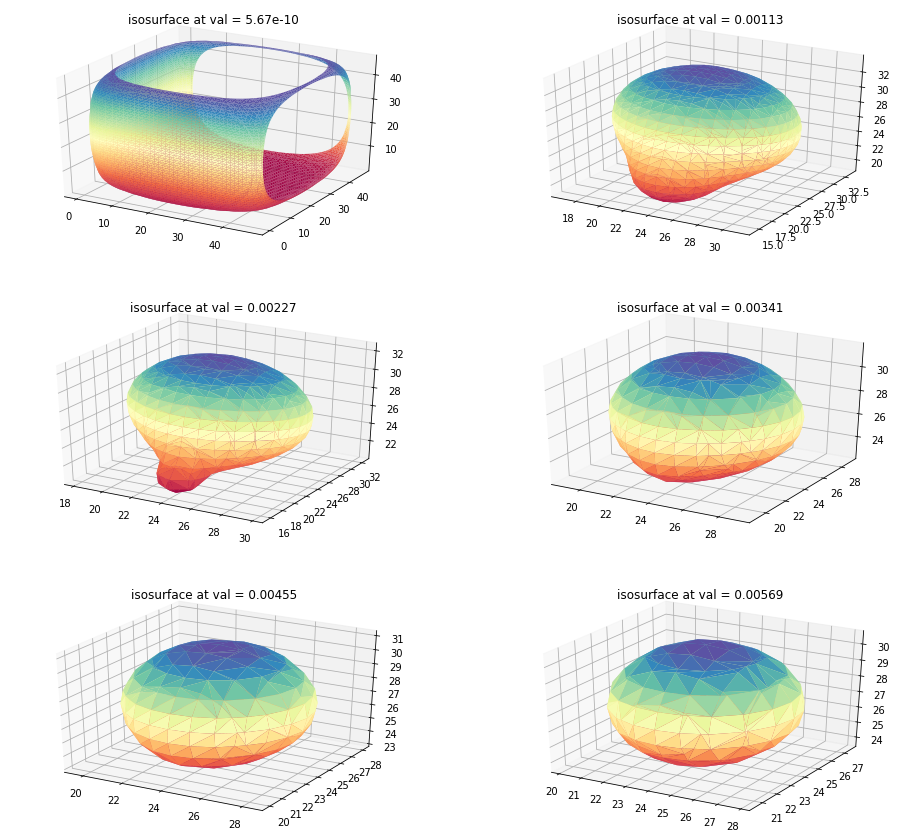

In [22]:
fig = isosurfLog(h2o_rho,interval=[0,0.01],margin=1e-9)

In [23]:
W(h2o_cube_data).min()

/opt/bwhpc/common/devel/python/3.6.3.20171114/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


0.0

In [24]:
W(h2o_cube_data).max()

/opt/bwhpc/common/devel/python/3.6.3.20171114/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


0.99999998003776225

/opt/bwhpc/common/devel/python/3.6.3.20171114/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


Data maximum 0.9999999800377622.
Data minimum 0.0.
Span of data 0.9999999800377622.


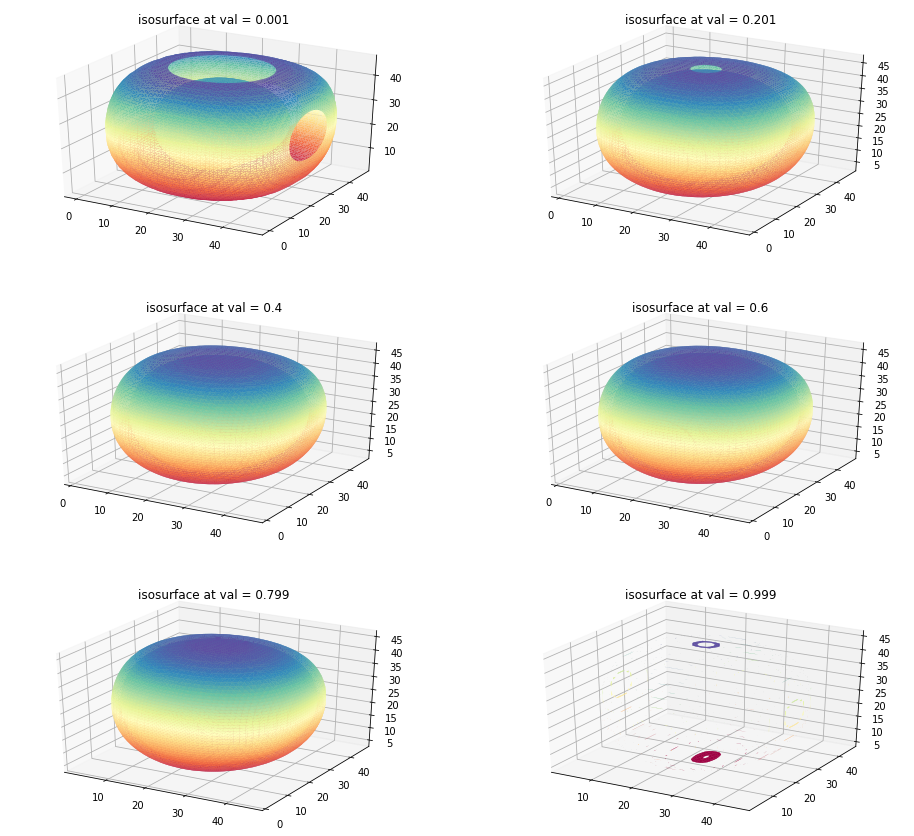

In [25]:
fig = isosurf(W(h2o_cube_data),margin=1e-3)

In [30]:
h2o_weights_cube = 'examples/h2o.weights.cube'

In [31]:
write(filename=h2o_weights_cube, images=h2o_cube_atoms, data=W(h2o_cube_data))

/opt/bwhpc/common/devel/python/3.6.3.20171114/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


pylab imported


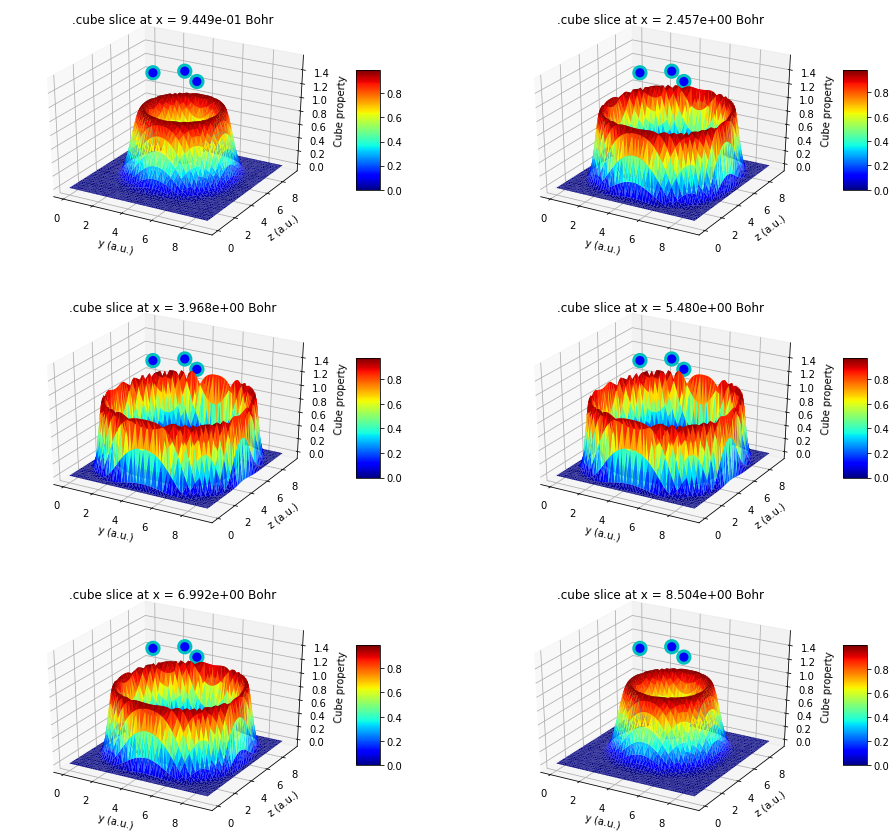

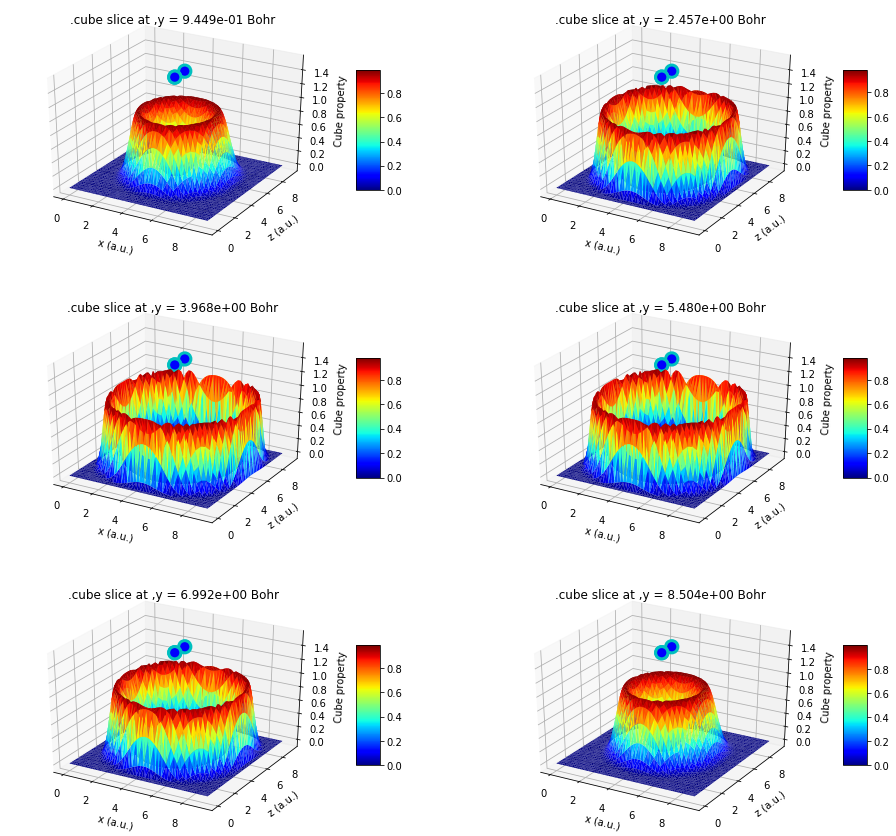

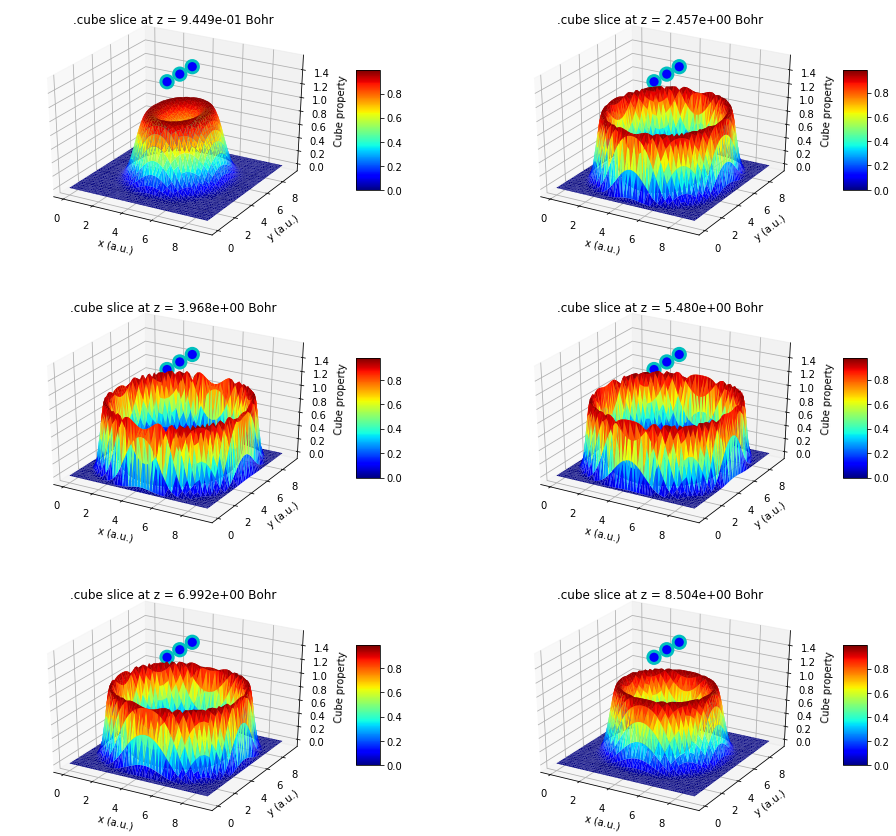

In [32]:
fig = sliceXYZ(h2o_weights_cube)

# Benzene

In [100]:
from cube2xyz import cube2xyz
from cube2xyz import plotSection2D

In [103]:
benzene_weights_cube = 'benzene/wdens_neg/benzene.weights.lnrhoref.-9.cube'

In [104]:
benzene_weights_cube_data, benzene_weights_cube_atoms = read_cube_data(benzene_weights_cube)

In [ ]:
fig = isosurf(benzene_weights_cube_data,margin=1e-3)

Data maximum 1.0.
Data minimum 0.0.
Span of data 1.0.


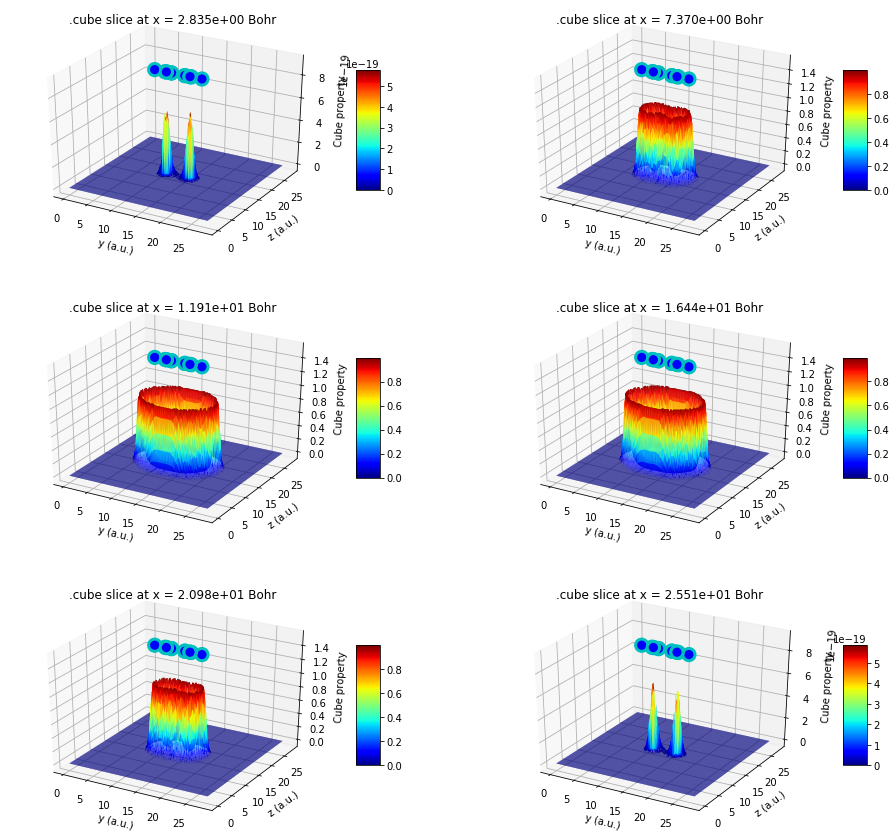

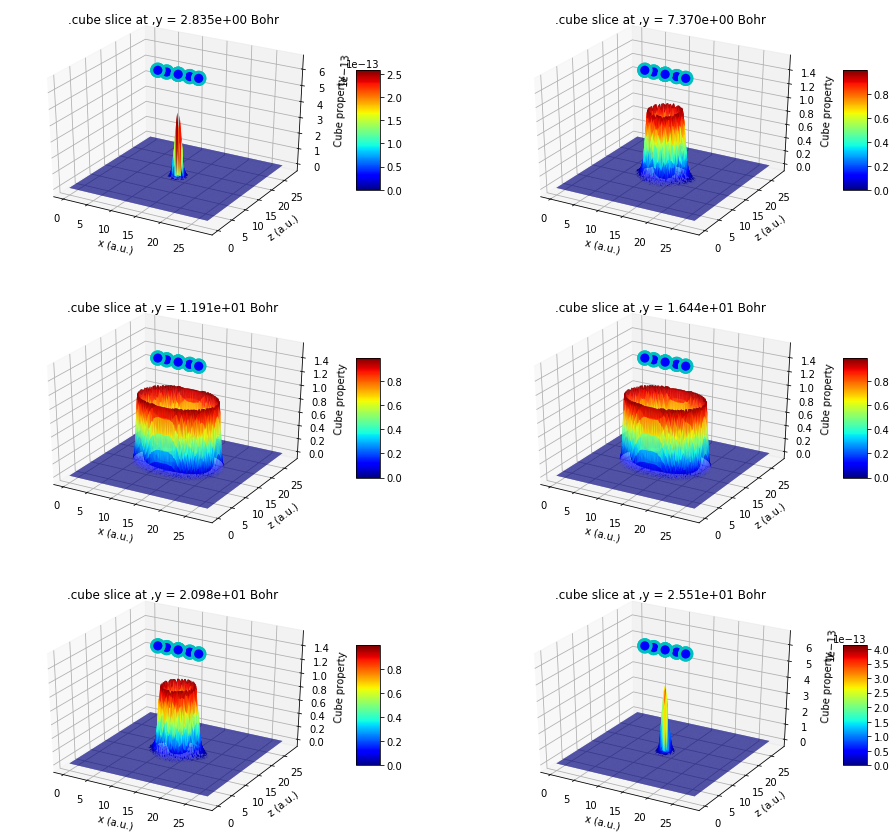

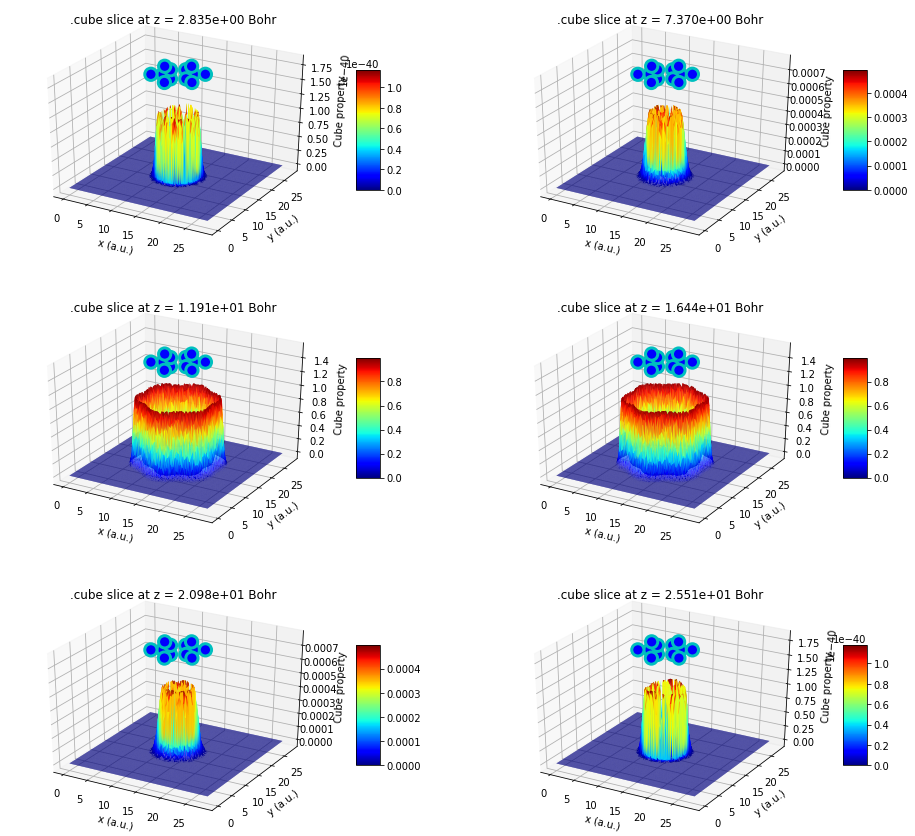

In [114]:
fig = sliceXYZ(benzene_weights_cube_data,benzene_weights_cube_atoms)

# SMAMP

In [98]:
infile_rho_cube = 'sandbox/system100.rho.cube'
rho_cube_data, rho_cube_atoms = read_cube_data(infile_rho_cube)

In [99]:
infile_rho_pseudo_cube = 'sandbox/system100.rho_pseudo.cube'
rho_pseudo_cube_data, rho_pseudo_cube_atoms = read_cube_data(infile_rho_pseudo_cube)

## rho check

In [100]:
rho_unit_cell = rho_cube_atoms.cell.diagonal() / rho_cube_data.shape
rho_unit_volume = np.prod(rho_unit_cell) 

In [101]:
rho_unit_cell

array([ 0.10080667,  0.10080667,  0.10080667])

In [102]:
rho_unit_volume

0.0010243958728087515

In [103]:
rho_ASE_normalized = rho_cube_data*rho_unit_volume/Bohr**3 # rho in Bohrb

In [104]:
rho_cube_data.min(),rho_cube_data.max()

(-1.6900770000000001e-19, 103.63939999999999)

In [105]:
rho_ASE_normalized.min(),rho_ASE_normalized.max()

(-1.1683444868623348e-21, 0.71645565031486891)

In [106]:
q_el = rho_ASE_normalized.sum() # integrate electron density
q_core = 0
for a in rho_cube_atoms: # count positive core charges
    q_core += a.number

In [107]:
# electron charge, core charge, system net charge
q_el, q_core, q_core - q_el
# obviously all electron charge density

(488.00318759869998, 494, 5.9968124013000192)

In [108]:
rho_cube_data.mean()

0.0046281049025134061

## rho pseudo check

In [44]:
rho_pseudo_unit_cell = rho_pseudo_cube_atoms.cell.diagonal() / rho_pseudo_cube_data.shape
rho_pseudo_unit_volume = np.prod(rho_pseudo_unit_cell) 

In [45]:
rho_pseudo_unit_cell

array([ 0.20161281,  0.20161281,  0.20161281])

In [46]:
rho_pseudo_unit_volume

0.0081951024527492904

In [47]:
rho_pseudo_ASE_normalized = rho_pseudo_cube_data*rho_pseudo_unit_volume/Bohr**3 # rho in Bohrb

In [48]:
rho_pseudo_cube_data.min(),rho_pseudo_cube_data.max()

(-1.6900770000000001e-19, 0.82627790000000001)

In [49]:
rho_pseudo_ASE_normalized.min(),rho_pseudo_ASE_normalized.max()

(-9.3466822974297263e-21, 0.045695888534589904)

In [50]:
rho_pseudo_q_el = rho_pseudo_ASE_normalized.sum() # integrate electron density
rho_pseudo_q_core = 0
for a in rho_pseudo_cube_atoms: # count positive core charges
    rho_pseudo_q_core += a.number

In [51]:
# electron charge, core charge, system net charge
rho_pseudo_q_el, rho_pseudo_q_core, rho_pseudo_q_core - rho_pseudo_q_el
# obviously PSEUDO

(348.64353183963817, 494, 145.35646816036183)

## weights

In [97]:
rho_cube_data.min(), rho_cube_data.max()

(0.0, 103.63939999999999)

In [61]:
rho_cube_data[rho_cube_data < 0.0] = 0.0 # remove slightly negative values

In [64]:
W(rho_cube_data).min(), W(rho_cube_data).max()

/opt/bwhpc/common/devel/python/3.6.3.20171114/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


(0.0, 0.99999999999798383)

In [65]:
rho_pseudo_cube_data.min(), rho_pseudo_cube_data.max()

(-1.6900770000000001e-19, 0.82627790000000001)

In [66]:
rho_pseudo_cube_data[rho_pseudo_cube_data < 0.0] = 0.0 # remove slightly negative values

In [68]:
W(rho_pseudo_cube_data).min(), W(rho_pseudo_cube_data).max()

/opt/bwhpc/common/devel/python/3.6.3.20171114/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


(0.0, 0.99999999996672495)

Data maximum 103.6394.
Data minimum 0.0.
Span of data 103.6394.
Shift data by -1.0.
Span of logarithms: 2.0196952407523994.
Magnitude of logarithm: 2.0196952407523994.
Plot isosurfaces of normalized log values in interval [0, 0.01]


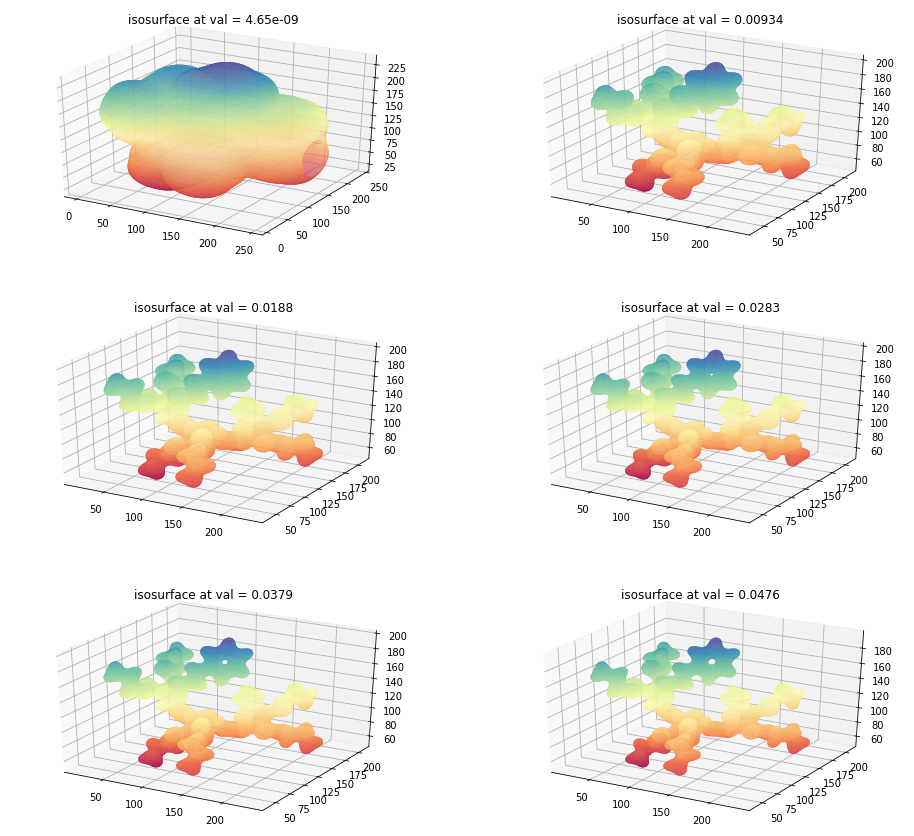

In [69]:
fig = isosurfLog(rho_cube_data,interval=[0,0.01],margin=1e-9)

Data maximum 0.8262779.
Data minimum 0.0.
Span of data 0.8262779.
Shift data by -1.0.
Span of logarithms: 0.2615668636985423.
Magnitude of logarithm: 0.2615668636985423.
Plot isosurfaces of normalized log values in interval [0, 0.01]


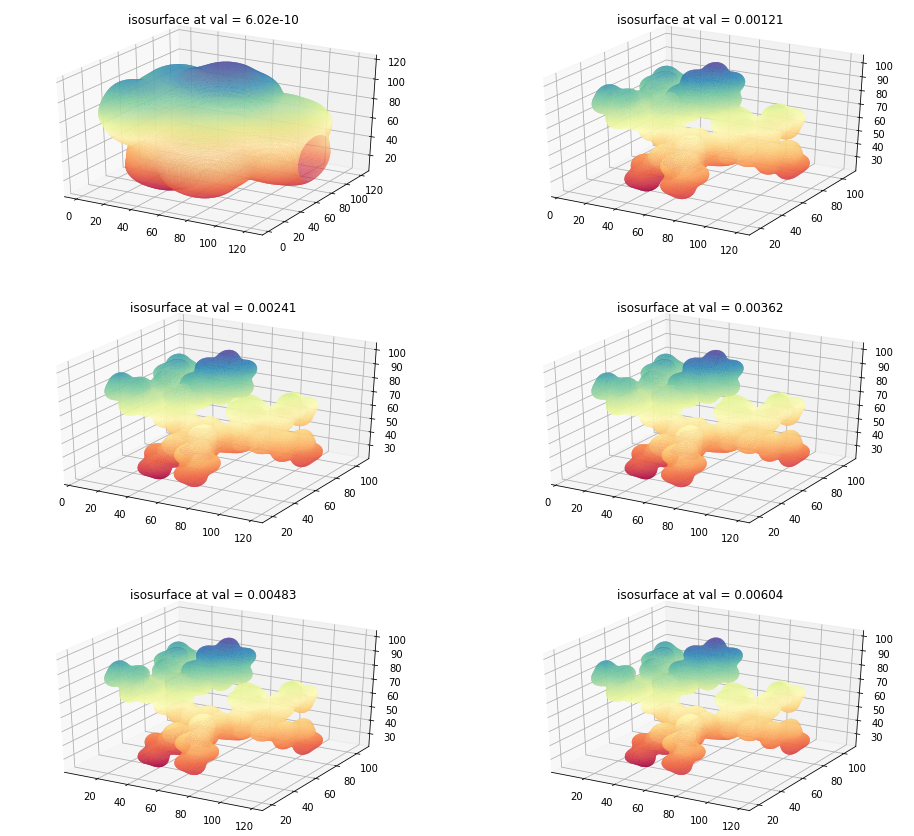

In [70]:
fig = isosurfLog(rho_pseudo_cube_data,interval=[0,0.01],margin=1e-9)

/opt/bwhpc/common/devel/python/3.6.3.20171114/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


Data maximum 0.9999999999979838.
Data minimum 0.0.
Span of data 0.9999999999979838.


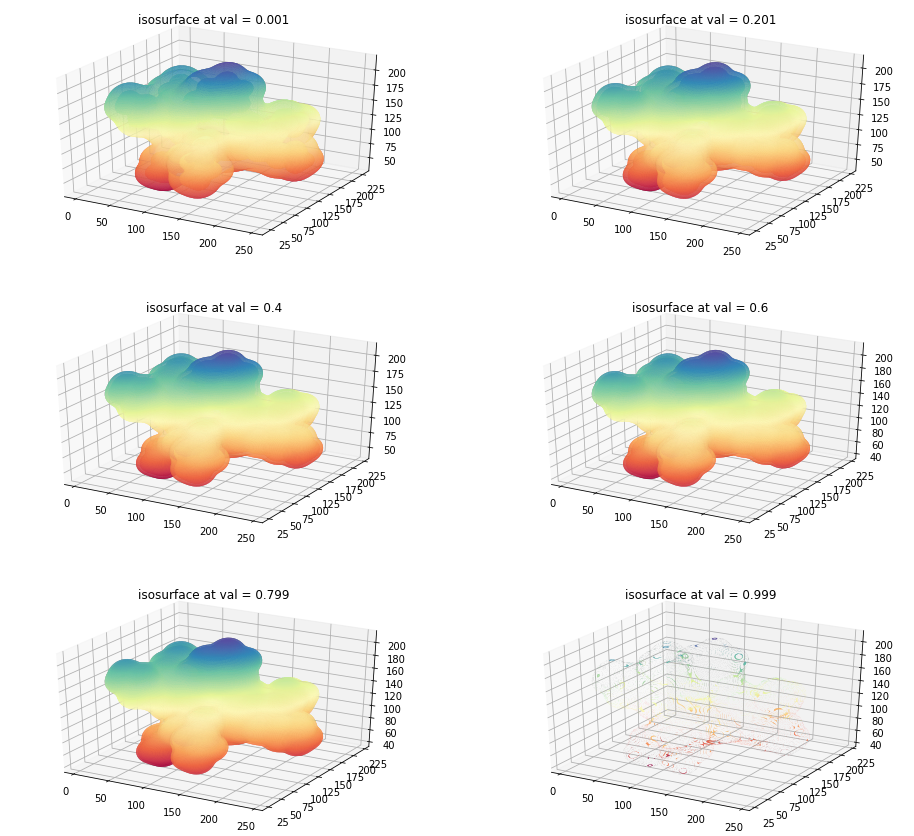

In [77]:
fig = isosurf(W(rho_cube_data),margin=1e-3)

/opt/bwhpc/common/devel/python/3.6.3.20171114/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


Data maximum 0.9999999999979838.
Data minimum 0.0.
Span of data 0.9999999999979838.


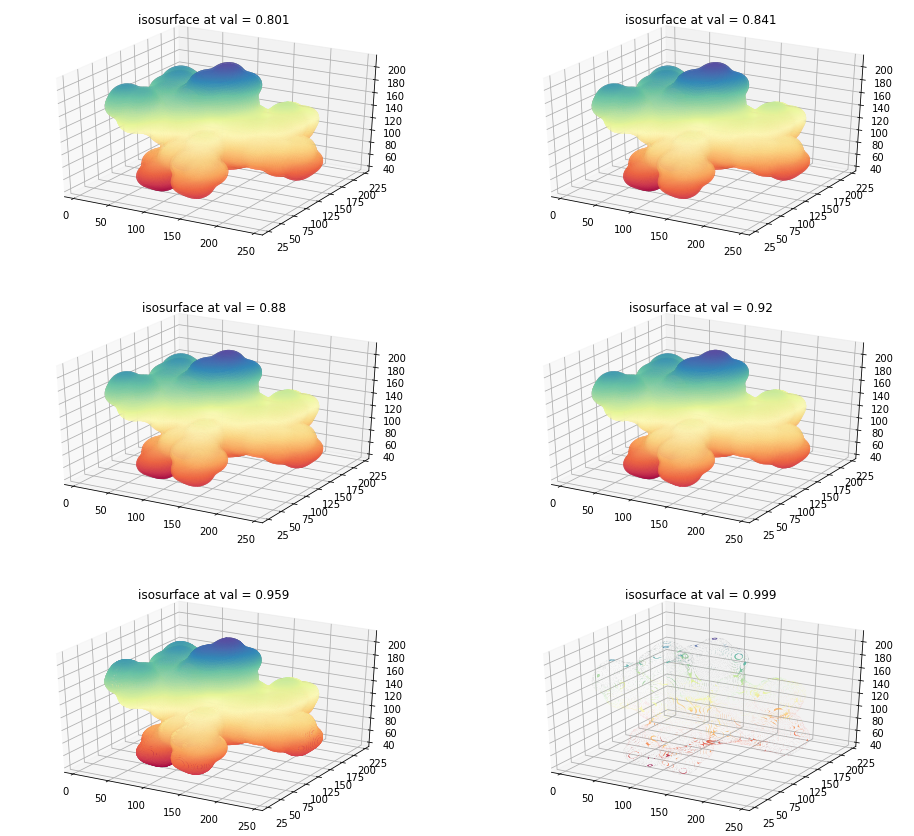

In [79]:
fig = isosurf(W(rho_cube_data),margin=1e-3,interval=[0.8,1.0])

/opt/bwhpc/common/devel/python/3.6.3.20171114/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


Data maximum 0.999999999966725.
Data minimum 0.0.
Span of data 0.999999999966725.


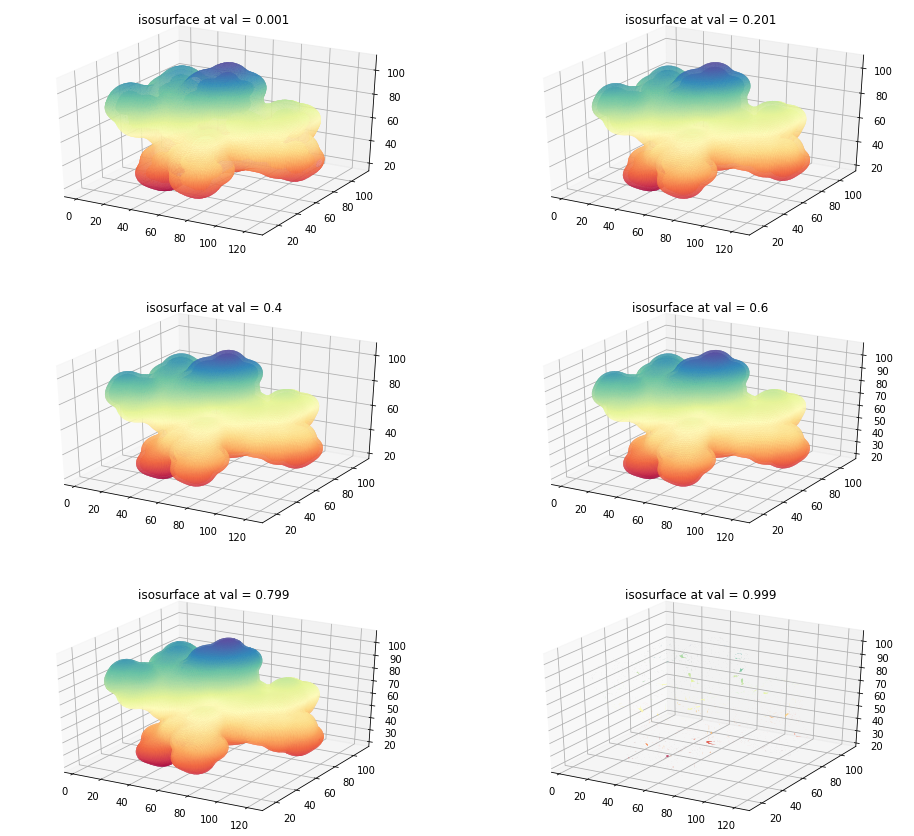

In [78]:
fig = isosurf(W(rho_pseudo_cube_data),margin=1e-3)

/opt/bwhpc/common/devel/python/3.6.3.20171114/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


Data maximum 0.999999999966725.
Data minimum 0.0.
Span of data 0.999999999966725.


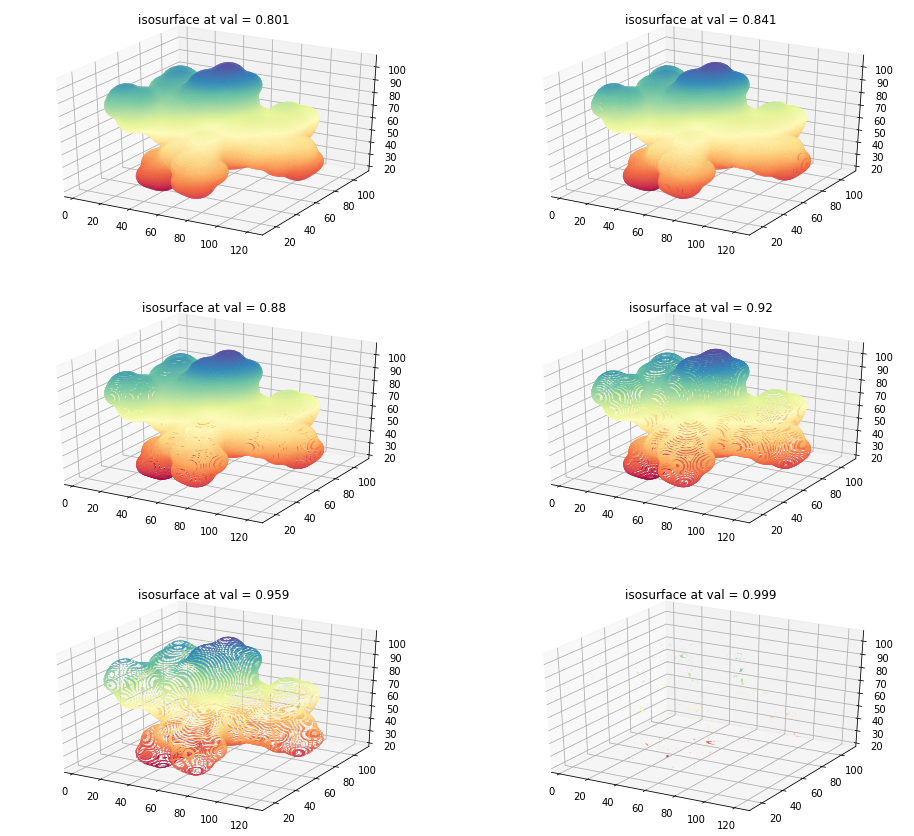

In [80]:
fig = isosurf(W(rho_pseudo_cube_data),margin=1e-3,interval=[0.8,1.0])

In [73]:
rho_weights_cube = 'sandbox/system100.rho_weights.cube'
rho_pseudo_weights_cube = 'sandbox/system100.rho_pseudo_weights.cube'

In [74]:
write(filename=rho_weights_cube, images=rho_cube_atoms, data=W(rho_cube_data))

/opt/bwhpc/common/devel/python/3.6.3.20171114/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [75]:
write(filename=rho_pseudo_weights_cube, images=rho_pseudo_cube_atoms, data=W(rho_pseudo_cube_data))

/opt/bwhpc/common/devel/python/3.6.3.20171114/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [20]:
fig = sliceXYZ(rho_weights_cube)

NameError: name 'rho_weights_cube' is not defined

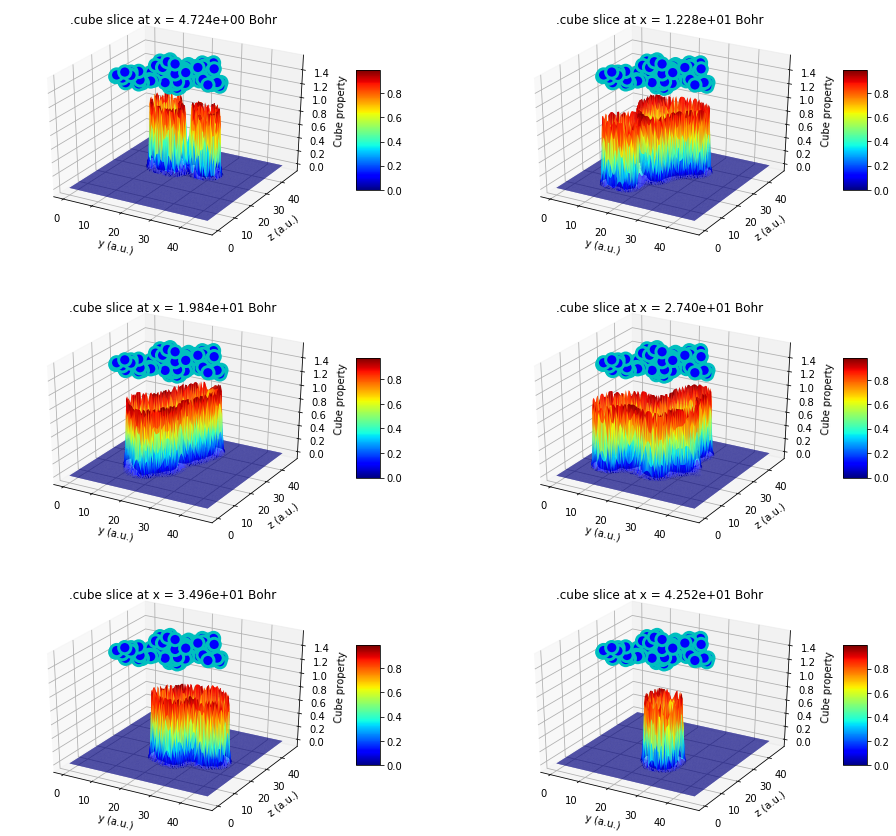

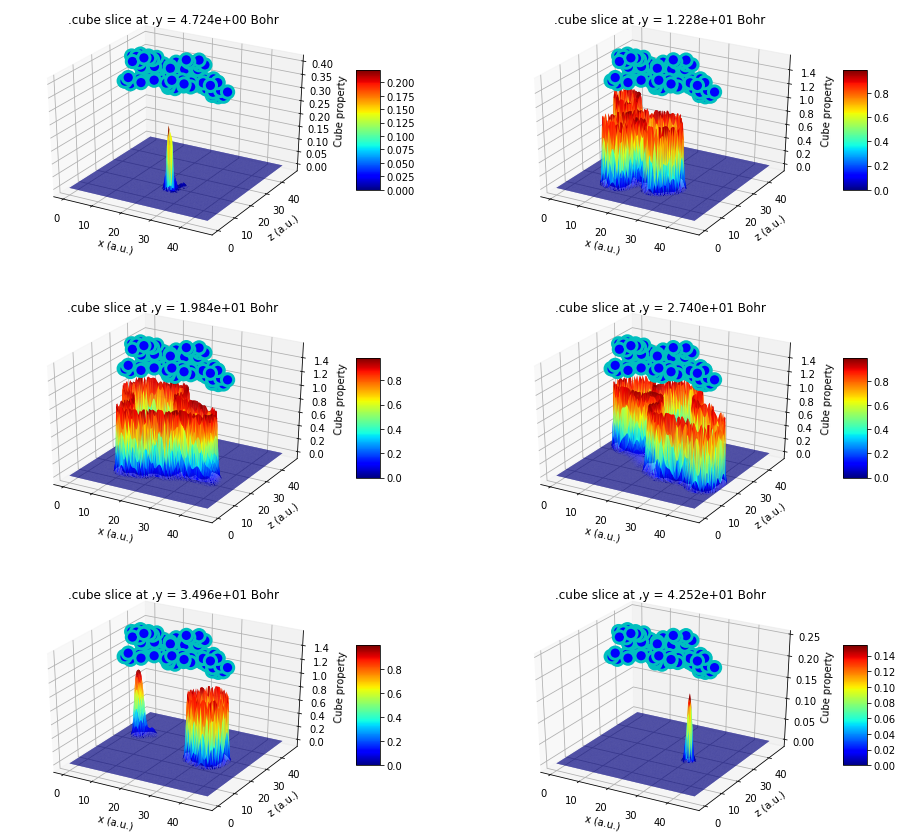

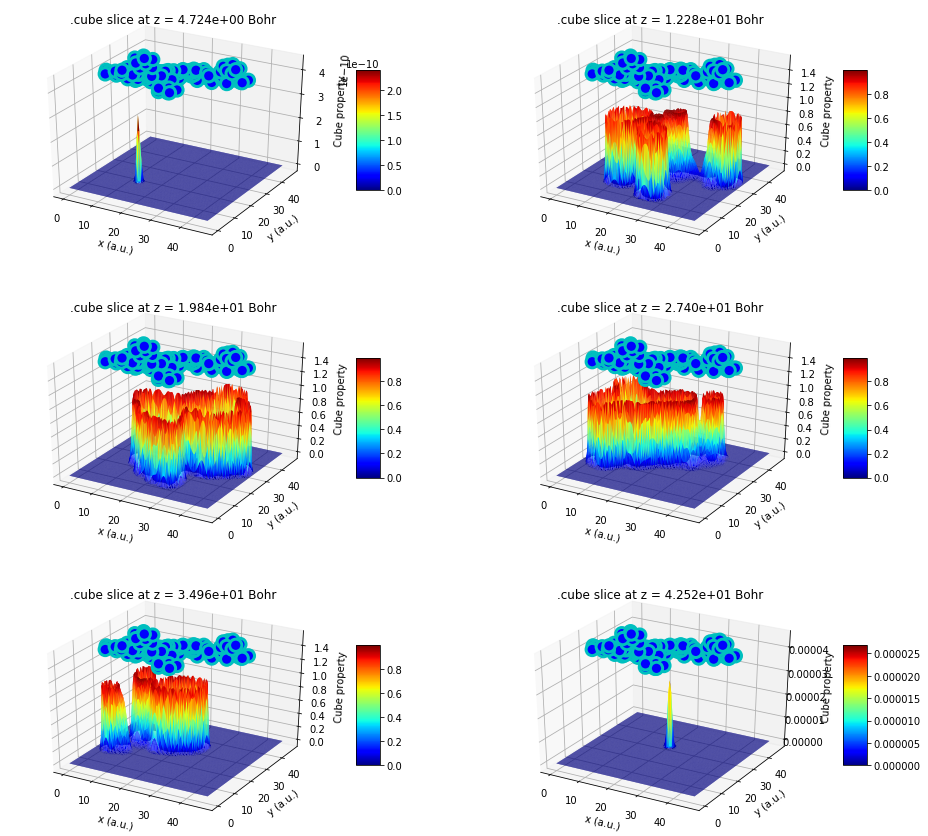

In [81]:
fig = sliceXYZ(rho_pseudo_weights_cube)

In [83]:
### HORTON weights

In [86]:
infile_weights_cube = 'sandbox/system100.weights_ua.cube'
weights_cube_data, weights_cube_atoms = read_cube_data(infile_weights_cube)

Data maximum 1.0.
Data minimum 0.0.
Span of data 1.0.


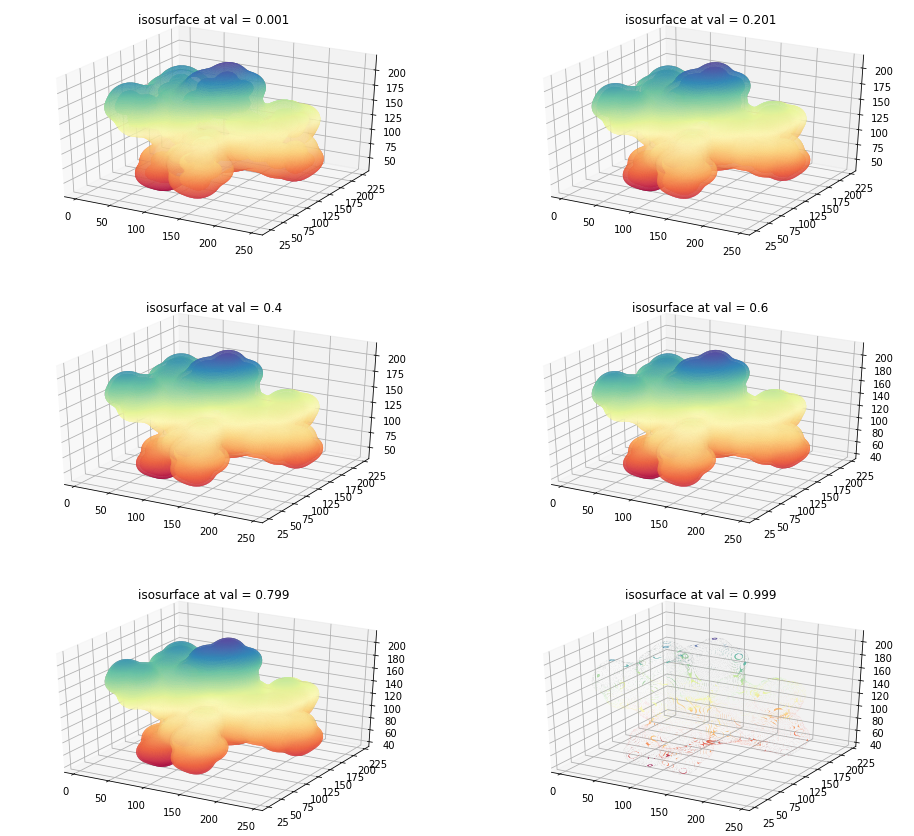

In [87]:
fig = isosurf(weights_cube_data,margin=1e-3)

Data maximum 1.0.
Data minimum 0.0.
Span of data 1.0.


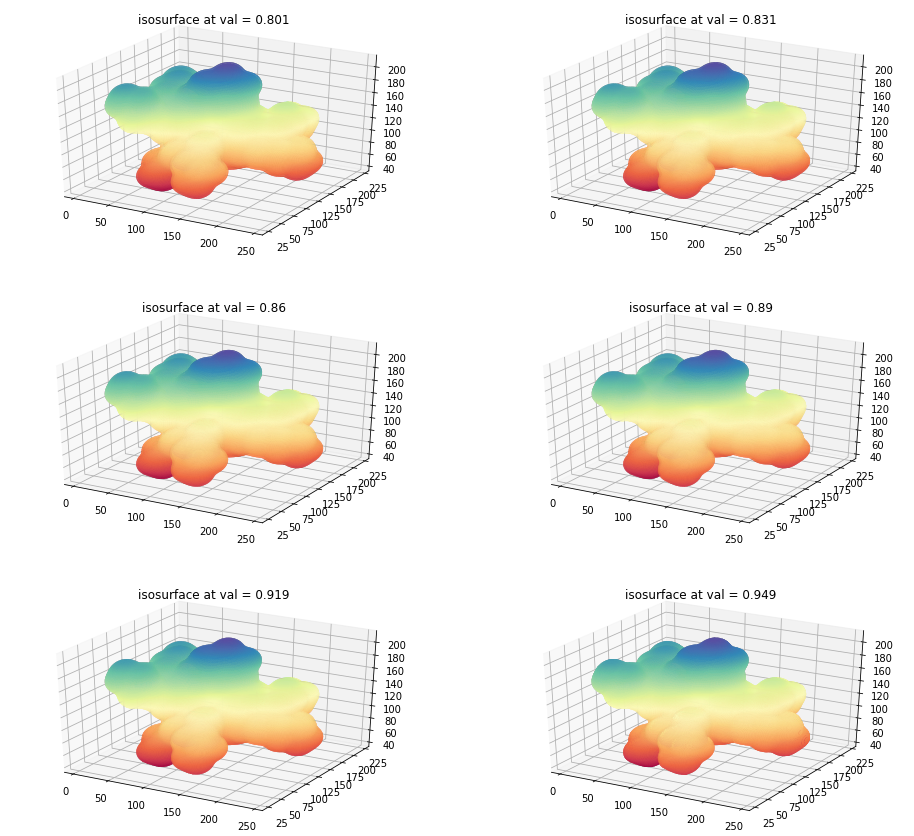

In [89]:
fig = isosurf(weights_cube_data,margin=1e-3,interval=[0.8,0.95])

# Functions

In [4]:
def isosurfLog(data, sections=6, margin=1e-2,cols=2,width=8,height=5,sign=1.0,base=10,interval=[]):
    cube_data = data
    
    cube_data = cube_data * sign
    
    data_span = cube_data.max()-cube_data.min()
    print("Data maximum {}.".format(cube_data.max()))
    print("Data minimum {}.".format(cube_data.min()))


    print("Span of data {}.".format(data_span))

    data_offset = cube_data.min() - 1
    print("Shift data by {}.".format(data_offset))
    
    #normalized_data = (cube_data - data_offset)
    cube_log_data = np.log(cube_data - data_offset ) / np.log(base)
    data_log_max = cube_log_data.max() 
    data_log_span = cube_log_data.max() - cube_log_data.min()
    print("Span of logarithms: {}.".format(data_log_span))
    print("Magnitude of logarithm: {}.".format(data_log_max))

    normalized_log_data = cube_log_data / data_log_max
    # margin = data_log_span * margin_relative
    if not interval:
        interval = [ normalized_log_data.min(), normalized_log_data.max() ]
        
    print("Plot isosurfaces of normalized log values in interval {}".format(interval))
    normalized_log_iso_vals = np.linspace(interval[0]+margin,interval[1]-margin,sections)

    iso_vals = (base**(normalized_log_iso_vals*data_log_max) + data_offset)*sign
    #exponents = np.linspace(0+margin,np.log(data_span+offset-margin)/np.log(base),P)
    #levels = base**exponents-offset
    #if sign < 0: # descending order
    #    isopots = cube_data.max() - levels
    #else: # ascending order
    #    isopots = cube_data.min() + levels
     
    rows = round(sections/cols)

    fig, axes = plt.subplots(rows,cols,figsize=(cols*width,rows*height),subplot_kw={'projection':'3d'})
    p = 0
    for i in range(rows):
        for j in range(cols):
            if p < sections:
                #tmp_ax = fig.add_subplot(pos,projection='3d')
                #phi = cube_data.min() + round(stride*(p+0.5))
                verts, faces, normals, values = \
                    measure.marching_cubes(normalized_log_data, normalized_log_iso_vals[p])
                axes[i,j].set_title("isosurface at val = {:.3g}".format(iso_vals[p]))
                axes[i,j].plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2],
                            cmap='Spectral', lw=1)
                p += 1
            else: 
                break
        
    return fig

In [5]:
def isosurf(data, sections=6, margin=1e-2,cols=2,width=8,height=5,sign=1.0,base=10,interval=[]):
    #cube_data = data
    
    data = data * sign
    
    data_span = data.max() - data.min()
    print("Data maximum {}.".format(data.max()))
    print("Data minimum {}.".format(data.min()))


    print("Span of data {}.".format(data_span))

    #data_offset = cube_data.min() - 1
    #print("Shift data by {}.".format(data_offset))
    
    #normalized_data = (cube_data - data_offset)
    #cube_log_data = np.log(cube_data - data_offset ) / np.log(base)
    #data_log_max = cube_log_data.max() 
    #data_log_span = cube_log_data.max() - cube_log_data.min()
    #print("Span of logarithms: {}.".format(data_log_span))
    #print("Magnitude of logarithm: {}.".format(data_log_max))

    #normalized_log_data = cube_log_data / data_log_max
    # margin = data_log_span * margin_relative
    if not interval:
        interval = [ data.min(), data.max() ]
        
    #print("Plot isosurfaces of normalized log values in interval {}".format(interval))
    iso_vals = np.linspace(interval[0]+margin,interval[1]-margin,sections)

    #iso_vals = (base**(normalized_log_iso_vals*data_log_max) + data_offset)*sign
    #exponents = np.linspace(0+margin,np.log(data_span+offset-margin)/np.log(base),P)
    #levels = base**exponents-offset
    #if sign < 0: # descending order
    #    isopots = cube_data.max() - levels
    #else: # ascending order
    #    isopots = cube_data.min() + levels
     
    rows = round(sections/cols)

    fig, axes = plt.subplots(rows,cols,figsize=(cols*width,rows*height),subplot_kw={'projection':'3d'})
    p = 0
    for i in range(rows):
        for j in range(cols):
            if p < sections:
                #tmp_ax = fig.add_subplot(pos,projection='3d')
                #phi = cube_data.min() + round(stride*(p+0.5))
                verts, faces, normals, values = \
                    measure.marching_cubes(data, iso_vals[p])
                axes[i,j].set_title("isosurface at val = {:.3g}".format(iso_vals[p]))
                axes[i,j].plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2],
                            cmap='Spectral', lw=1)
                p += 1
            else: 
                break
        
    return fig

In [113]:
def sliceXYZ(cube_data,cube_atoms, sections=6, margin_relative=1e-1,cols=2,width=8,height=5):
    from ase.units import Bohr
    #from cube2xyz import cube2xyz
    #from cube2xyz import plotSection2D
    #cube_data, cube_atoms = read_cube_data(infile_cube)
    
    X = cube_atoms.cell.diagonal()/Bohr
    #X = cube_atoms.cell.diagonal() # JUST FOR NOW
    
    print("Slicing box of {} Bohr...".format(X))
    margin = margin_relative * X
    #cols = 2
    rows = round(sections/cols)
    print("Displaying {:d} sections in {:d} rows and {:d} cols.".format(sections,rows,cols))

    fig = []
    axes = []
    dim_label= ["x",",y","z"]
    for dim in range(X.shape[0]):
        #L = X.shape[3]
        x = np.linspace(margin[dim],X[dim]-margin[dim],sections)

        print("Processing {} Bohr slices in {} direction...".format(x,dim_label[dim]))

        tmp_fig, tmp_axes = plt.subplots(rows,cols,figsize=(cols*width,rows*height),subplot_kw={'projection':'3d'})
        p = 0
        for i in range(rows):
            for j in range(cols):
                if p < sections:
                    print("Calling cube2xyz.plotSection2D at slice {} = {} Bohr...".format(dim_label[dim],x[p]))

                    tmp_ax = plotSection2D(cube_data,cube_atoms, position=x[p], axis=dim, ax=tmp_axes[i,j])
                    tmp_ax.set_title(".cube slice at {} = {:.3e} Bohr".format(dim_label[dim],x[p]))
                    #cube2xyz(infile_cube, y_coord=x[p],output=False, mpl=True,ax=axes[i,j])
                    p += 1
                else:
                    break

        fig.append(tmp_fig)
        axes.append(tmp_axes)
        
    return fig

In [112]:
def plotSection2D(cube_data,cube_atoms, position, axis=0, ax=False, output=False):
    """
    Plots a crosssectional landscape of an ASE cube data representation 
    and the according atom position projections.
    
    Parameters
    ----------
    cube_data:
        data read from a cube file with ase.io.cube.read_cube_data(...)
    cube_atoms:
        atoms read from a cube file with ase.io.cube.read_cube_data(...)
        While .cube files conventionally use Bohr as the spatial unit,
        ASE uses Angstrom internally. Thus, atom positions and box measures
        are treated as ASE Angstrom within this data structure and converted 
        to atomic units (i.e. Bohr) for plotting in this function.
    position:
        Position along specified axis in Bohr
        ATTENTION: Should be Bohr, but apparently still Angstrom.
        Why?
    axis:
        Axis normal to desired crossection, i.e. '0', '1' or '2', or
        equivalently 'x', 'y' or 'z'.
    ax:
        default 'False'. If an axes object is given, the plot is done on these axes
        instead of creating new figure and axes.  
        
    Return
    ------
    axes:
        New or modified matplotlib.axes.Axes handle
    """
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    from mpl_toolkits.mplot3d import Axes3D
    if not ax:
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        
        
    if axis==0 or axis=="x":
        tmp_ax = cube2xyz(cube_data,cube_atoms, x_coord=position, mpl=True, output=output, show_plot=False, ax=ax)
    elif axis==1 or axis=="y":
        tmp_ax = cube2xyz(cube_data,cube_atoms, y_coord=position, mpl=True, output=output, show_plot=False, ax=ax)
    elif axis==2 or axis=="z":
        tmp_ax = cube2xyz(cube_data,cube_atoms, z_coord=position, mpl=True, output=output, show_plot=False, ax=ax)
        
    return tmp_ax

In [111]:
def cube2xyz(cube_data, cube_atoms, outfile_dat="", print_range="", x_coord="", y_coord="", 
    z_coord="", mpl=True, aa=1.0, output=True, p_label=" (a.u.)", show_plot=False, ax=False ):
    """
    Plots a crosssectional landscape or axial profile 
    of an ASE cube data representation 
    and the according atom position projection.
    
    Parameters
    ----------
    cube_data:
        data read from a cube file with ase.io.cube.read_cube_data(...)
    cube_atoms:
        atoms read from a cube file with ase.io.cube.read_cube_data(...)
        While .cube files conventionally use Bohr as the spatial unit,
        ASE uses Angstrom internally. Thus, atom positions and box measures
        are treated as ASE Angstrom within this data structure and converted 
        to atomic units (i.e. Bohr) for plotting in this function.
    outfile_dat:
        data of selection written to this outfile instead of stdout.
        EXPERIMENTAL
    print_range:
        'x', 'y' or 'z'. Prints all discretization points along this axis
        EXPERIMENTAL
        and exits.
    x_coord, y_coord, z_coord:
        specifies position of 2D crossection (if one of these specified)
        or 1D profile (if two of these specified)
    mpl:
        default 'True'. Plots with Matplotlib.
    aa: 
        Scaling factor. Default '1.0' results in Bohr scaling (see above)
    output:
        default 'True'. Whether or not to print some info.
    p_label:
        default ' (a.u.)'. Label for spatial axes on plot.
    show_plot:
        default 'False': Handle to newly created or modified Matplotlib
        axes object is returned, but plot not displayed.
    ax:
        default 'False'. If an axes object is given, the plot is done on these axes
        instead of creating new figure and axes.  

    Return
    ------
    axes:
        New or modified matplotlib.axes.Axes handle
    """
    
    # the adaption of this function from http://larrucea.eu/cube2xyz/ and
    # https://github.com/julenl/molecular_modeling_scripts/blob/master/cube2xyz/cube2xyz-v0.1.py
    # is just ugly. At some point, do proper implementation.
    
    import sys, os
    import numpy as np
    from ase.units import Bohr

    print("Options: \n",
        "{:>20}:{:>20}\n".format("outfile_dat",outfile_dat), 
        "{:>20}:{:>20}\n".format("print_range",print_range),
        "{:>20}:{:>20}\n".format("x_coord",x_coord),
        "{:>20}:{:>20}\n".format("y_coord",y_coord),
        "{:>20}:{:>20}\n".format("z_coord",z_coord),
        "{:>20}:{!s:>20}\n".format("mpl",mpl),
        "{:>20}:{:20.2e}\n".format("aa",aa),
        "{:>20}:{!s:>20}\n".format("output",output),
        "{:>20}:{:>20}\n".format("p_label",p_label) )
    at_coord=[]
    spacing_vec=[]
    nline=0
    values=[]
    fig=0
    # Read cube file and parse all data
    # for line in open(infile_cube,"r"):
    #    nline+=1
    #    if nline==3:
    #        try:
    #            nat=int(line.split()[0]) 
    #            origin=[float(line.split()[1]),
    ##                float(line.split()[2]),float(line.split()[3])]
    #        except:
    #            print("ERROR: non recognized cube format")
    #    elif nline >3 and nline <= 6:
    #        spacing_vec.append(line.split())
    #    elif nline > 6 and nline <= 6+nat:
    #        at_coord.append(line.split())
    #    elif nline > 5:
    #        if nline > 6+nat:
    #            for i in line.split():
    #                values.append(float(i)) 
    nat = cube_atoms.get_number_of_atoms()
    # spacing_vec = cube_atoms.cell / cube_data.shape / Bohr
    # just for now: ugly matrix of shape and spacing
    spacing_vec = np.hstack([np.atleast_2d(cube_data.shape).T,
                             cube_atoms.cell / cube_data.shape / Bohr])
    # at_coord = cube_atoms.get_positions() / Bohr
    at_coord = np.hstack( 
        [ np.atleast_2d(cube_atoms.get_atomic_numbers()).T, 
         np.zeros( ( cube_atoms.get_number_of_atoms(), 1) ),
         cube_atoms.get_positions() / Bohr ] )

    values = cube_data.flatten()
    
    # print(" ")
    def frange(x, y, jump):
        while x < y:
            yield x
            x += jump

    idx=-1

    if print_range != "":
        print(print_range+" range:")
        if print_range == "x":
            for i in range(0,int(spacing_vec[0][0])):
                print(i*float(spacing_vec[0][1])*aa)
        if print_range == "y":
            for i in range(0,int(spacing_vec[1][0])):
                print(i*float(spacing_vec[1][2])*aa)
        if print_range == "z":
            for i in range(0,int(spacing_vec[2][0])):
                print(i*float(spacing_vec[2][3])*aa)
            sys.exit()


    # The filter should work on Bohr coordinates
    filter=""  # Create a filter for the values on a segment or plane
    if x_coord != "":
        filter=filter+ " x > " \
            + str(float(x_coord)-0.9*float(spacing_vec[0][1])) + " and x < " \
            + str(float(x_coord)+0.9*float(spacing_vec[0][1])) + " "
    if y_coord != "":
        if x_coord != "": 
            filter=filter+" and "
        filter=filter+ " y > " \
            + str(float(y_coord)-0.9*float(spacing_vec[1][2]))+" and y < " \
            + str(float(y_coord)+0.9*float(spacing_vec[1][2])) + " "
    if z_coord != "":
        if len(filter)> 3:
            filter=filter+" and "
        filter=filter+ " z > " \
            + str(float(z_coord)-0.9*float(spacing_vec[2][3])) + " and z < " \
            + str(float(z_coord)+0.9*float(spacing_vec[2][3])) + " "
    if filter=="":
        filter="1==1"
        
    print("Filter: {}".format(filter))

     # Set parameter for type of plot
    plttmp=[]
    xyzs=""
    if x_coord:
        plttmp.append(x_coord)
        xyzs=xyzs+"x"
    if y_coord:
        plttmp.append(y_coord)
        xyzs=xyzs+"y"
    if z_coord:
        plttmp.append(z_coord)
        xyzs=xyzs+"z"
    plot_dim=4-len(plttmp)
    # print(" Representing "+str(plot_dim)+"D data...", xyzs) 


      #Print x,y,z,value data to stdout, file or not at all
    data=[]
    
    #print("Spacing vectors: {}".format(spacing_vec))

    if outfile_dat and output:
        #if output file name is provided, print to file instead of STD out
        tmp=sys.stdout
        sys.stdout = open(outfile_dat,'w')
    if not output:
        tmp=sys.stdout
        sys.stdout = open(os.devnull, 'w')

    print("Spacing vectors: {}".format(spacing_vec))
    for i in range(0,int(spacing_vec[0][0])):
        for j in range(0,int(spacing_vec[1][0])):
            for k in range(0,int(spacing_vec[2][0])):
                idx+=1
                x,y,z= i*float(spacing_vec[0][1]), \
                    j*float(spacing_vec[1][2]),k*float(spacing_vec[2][3])
                print("Looking at pos ({},{},{}).".format(x,y,z))
                if eval(filter):
                    print(x/aa,y/aa,z/aa, values[idx])
                    data.append([x/aa,y/aa,z/aa, values[idx]])
    
    print("Filtered {} data points.".format(len(data)))

    if outfile_dat or not output:
        sys.stdout.close()
        sys.stdout=tmp

    ylabel="Cube magnitude"
    axe_labels=["x","y","z"]
    if mpl:
        if plot_dim == 4:
            print("4D plot not implemented")
            sys.exit()

        if plot_dim == 3:
            var_axe1=list("xyz".replace(xyzs[0],""))[0]  
            var_axe2=list("xyz".replace(xyzs[0],""))[1]
            print("Plot in 3D: \n",
                "{:>20}:{:>20}\n".format("var_axe1",var_axe1), 
                "{:>20}:{:>20}\n".format("var_axe2",var_axe2),
                "{:>20}:{:>20}\n".format("axe_labels(var_axe1)",
                                         axe_labels.index(var_axe1)),
                "{:>20}:{:>20}\n".format("axe_labels(var_axe2)",
                                         axe_labels.index(var_axe2)),
                "{:>20}:{:>20}\n".format("len(data)", len(data)))
            
            from mpl_toolkits.mplot3d.axes3d import Axes3D
            from matplotlib import cm
            #X, Y =np.meshgrid(zip(*data)[axe_labels.index(var_axe1)],
            #    zip(*data)[axe_labels.index(var_axe2)])
            
            X,Y=list(zip(*data))[axe_labels.index(var_axe1)],\
                list(zip(*data))[axe_labels.index(var_axe2)]
            Z = list(zip(*data))[3]
            #print "max Z: ", max(Z)
            if not ax:
                fig = plt.figure()
                ax = fig.gca(projection='3d')
            
            # plt.hold(True)
            # surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
            #     cmap=cm.coolwarm, linewidth=0, antialiased=False)
            surf = ax.plot_trisurf(X, Y, Z, cmap=cm.jet, linewidth=0.2)
            fig = ax.figure
            fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
            

            ax.set_xlabel(var_axe1 + p_label)
            ax.set_ylabel(var_axe2 + p_label)
            ax.set_zlabel('Cube property')

            coord=[]
            print("at_coord: {}".format(at_coord))
            for c in at_coord: # Format atomic coordinates for plotting
                 coord.append([(float(c[2]))/aa,(float(c[3]))/aa,(float(c[4]))/aa])

            xc=list(zip(*coord))[axe_labels.index(var_axe1)]
            yc=list(zip(*coord))[axe_labels.index(var_axe2)]
            
            spanZ = max(Z) - min(Z)
            zc=[max(Z)+(spanZ*0.5)]*len(coord) #put atoms slightly higher than max val
            # projection of atoms centers above the graph
            ax.scatter(xc,yc,zc,s=150, c='b', marker='o',cmap=None, norm = None, 
                edgecolors='c', lw=3.0, alpha=1) 
           # for i in coord:

        if plot_dim == 2:  # when 2 variables are fixed a 2D plot is produced
            var_axe= "xyz".replace(xyzs[0],"").replace(xyzs[1],"")
            var_idx=axe_labels.index(var_axe)
            plot(list(zip(*data))[var_idx], list(zip(*data))[3])
            plt.xlabel(var_axe + p_label)
            plt.ylabel("Cube property")

        #plt.grid(True) 
        if show_plot:
            show()   
        
        #if fig:
        #    return fig
        if ax:
            return ax

# Sandbox

In [32]:
benzene_weights_cube_atoms.cell

array([[ 25.00005443,   0.        ,   0.        ],
       [  0.        ,  25.00005443,   0.        ],
       [  0.        ,   0.        ,  25.00005443]])

In [33]:
benzene_weights_cube_atoms.cell

array([[ 25.00005443,   0.        ,   0.        ],
       [  0.        ,  25.00005443,   0.        ],
       [  0.        ,   0.        ,  25.00005443]])

In [34]:
benzene_weights_cube_data.shape

(248, 248, 248)

In [86]:
benzene_weights_cube_atoms.cell / benzene_weights_cube_data.shape

array([[ 0.10080667,  0.        ,  0.        ],
       [ 0.        ,  0.10080667,  0.        ],
       [ 0.        ,  0.        ,  0.10080667]])

In [35]:
np.array(benzene_weights_cube_data.shape).T

array([248, 248, 248])

In [78]:
np.hstack([np.atleast_2d(benzene_weights_cube_data.shape).T,benzene_weights_cube_atoms.cell / benzene_weights_cube_data.shape / Bohr])

array([[  2.48000000e+02,   1.90497000e-01,   0.00000000e+00,
          0.00000000e+00],
       [  2.48000000e+02,   0.00000000e+00,   1.90497000e-01,
          0.00000000e+00],
       [  2.48000000e+02,   0.00000000e+00,   0.00000000e+00,
          1.90497000e-01]])

In [47]:
benzene_weights_cube_atoms.get_positions()

array([[ 12.50006875,  13.89511641,  12.50002695],
       [ 13.71118817,  13.19863612,  12.50002748],
       [ 13.71116065,  11.80129184,  12.50002695],
       [ 12.50001266,  11.10494014,  12.50002748],
       [ 11.2888271 ,  11.80141778,  12.50002695],
       [ 11.28885091,  13.1987663 ,  12.50002748],
       [ 12.50004335,  14.98571624,  12.50002748],
       [ 14.65506092,  13.74600909,  12.50002748],
       [ 14.65506304,  11.25400565,  12.50002748],
       [ 12.49999361,  10.01433818,  12.50002695],
       [ 10.34499298,  11.25405698,  12.50002748],
       [ 10.34499139,  13.74603819,  12.50002748]])

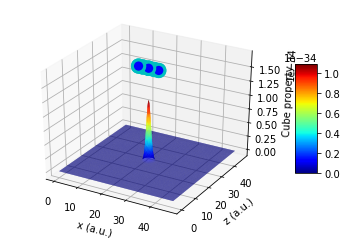

In [52]:
plotSection2D(benzene_weights_cube_data,benzene_weights_cube_atoms, 0.19047*3, axis=1)

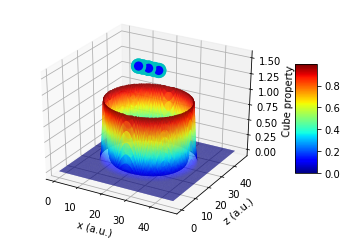

In [92]:
plotSection2D(benzene_weights_cube_data,benzene_weights_cube_atoms, 24, axis=1, output=True)

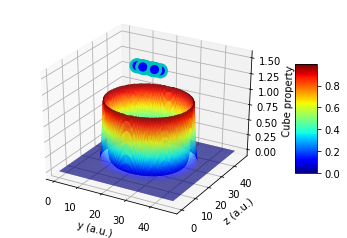

In [99]:
cube2xyz(benzene_weights_cube_data, benzene_weights_cube_atoms, 
         x_coord=24, output=True, show_plot=False, ax=False )

IndexError: list index out of range

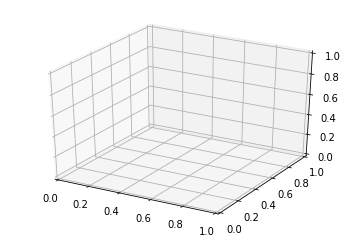

In [80]:
plotSection2D(benzene_weights_cube_data,benzene_weights_cube_atoms, 26, axis=1, output=True)

In [68]:
import cProfile

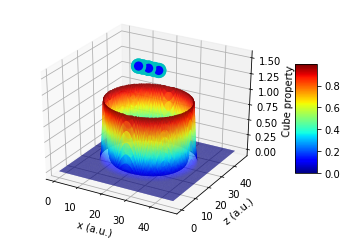

In [84]:
stats = cProfile.runctx("plotSection2D(benzene_weights_cube_data,benzene_weights_cube_atoms, 24, axis=1, output=True)",
                {'plotSection2D': plotSection2D,
                 'benzene_weights_cube_data': benzene_weights_cube_data, 
                 'benzene_weights_cube_atoms': benzene_weights_cube_atoms}, {})

In [87]:
type(stats)

NoneType

In [15]:
benzene_weights_cube_atoms.get_positions() / Bohr

array([[ 23.621655,  26.257913,  23.621576],
       [ 25.910339,  24.941756,  23.621577],
       [ 25.910287,  22.301158,  23.621576],
       [ 23.621549,  20.985244,  23.621577],
       [ 21.33274 ,  22.301396,  23.621576],
       [ 21.332785,  24.942002,  23.621577],
       [ 23.621607,  28.318848,  23.621577],
       [ 27.694   ,  25.976141,  23.621577],
       [ 27.694004,  21.266937,  23.621577],
       [ 23.621513,  18.924305,  23.621576],
       [ 19.549152,  21.267034,  23.621577],
       [ 19.549149,  25.976196,  23.621577]])

In [45]:
test_coord = np.hstack([np.atleast_2d(benzene_weights_cube_atoms.get_atomic_numbers()).T, 
                        np.zeros( ( benzene_weights_cube_atoms.get_number_of_atoms(), 1) ),
                        benzene_weights_cube_atoms.get_positions() / Bohr])

In [46]:
test_coord

array([[  6.      ,   0.      ,  23.621655,  26.257913,  23.621576],
       [  6.      ,   0.      ,  25.910339,  24.941756,  23.621577],
       [  6.      ,   0.      ,  25.910287,  22.301158,  23.621576],
       [  6.      ,   0.      ,  23.621549,  20.985244,  23.621577],
       [  6.      ,   0.      ,  21.33274 ,  22.301396,  23.621576],
       [  6.      ,   0.      ,  21.332785,  24.942002,  23.621577],
       [  1.      ,   0.      ,  23.621607,  28.318848,  23.621577],
       [  1.      ,   0.      ,  27.694   ,  25.976141,  23.621577],
       [  1.      ,   0.      ,  27.694004,  21.266937,  23.621577],
       [  1.      ,   0.      ,  23.621513,  18.924305,  23.621576],
       [  1.      ,   0.      ,  19.549152,  21.267034,  23.621577],
       [  1.      ,   0.      ,  19.549149,  25.976196,  23.621577]])

In [44]:
np.zeros((benzene_weights_cube_atoms.get_number_of_atoms(),1))

array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]])

In [31]:
for a in test_coord:
    print(a[2])

26.257913
24.941756
22.301158
20.985244
22.301396
24.942002
28.318848
25.976141
21.266937
18.924305
21.267034
25.976196
